# Goal

Can I create the 7th energy level of a Quantum Harmonic Oscillator, defined by $H = \frac{P^2}{2m} + \frac{1}{2}m \omega^2 X^2$, by fine tuning the $\omega$ parameter to follow a $\omega_t$ evolution?

# Imports

In [1]:
from copy import deepcopy
from dataclasses import dataclass
from functools import lru_cache
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.sparse.linalg import expm
import tensorflow as tf
import os
from typing import Optional
import numpy as np
import scipy
import seaborn as sns
from scipy.special import dtype

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' # disable Tensorflow's scary warnings stating that things are working well

plt.figure(figsize=(20,3))

2025-02-10 07:12:18.630131: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 07:12:18.639599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739167938.650777   46251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739167938.654038   46251 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 07:12:18.666074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

In [2]:
# Check GPU availability
# https://stackoverflow.com/a/77346053
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    # tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Sorry, no GPU for you...")

We got a GPU


In [3]:
@dataclass
class Settings:
    n_time_intervals:int = 10
    number_of_energy_levels:int = 10
    omega:float = tf.constant(10.)
    resolution:int = 500
    target_energy_level:int = 2
    # TODO: Automatise this total_evolution_time / n_time_intervals division
    time_delta:float = 10. / 10
    total_evolution_time:float = tf.constant(10.)
    x_max:float = tf.constant(2.)
    x_min:float = tf.constant(-2.)

assert Settings.time_delta * Settings.n_time_intervals == Settings.total_evolution_time

    # @property
    # def time_delta(self):
    #     return self.total_evolution_time / self.n_time_intervals


I0000 00:00:1739167940.247663   46251 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# Setup Hamiltonian

In [4]:
valid_x = tf.linspace(Settings.x_min, Settings.x_max, Settings.resolution)
delta_x = tf.constant(valid_x[1] - valid_x[0])

@tf.function
def potential(x):
    return x**2

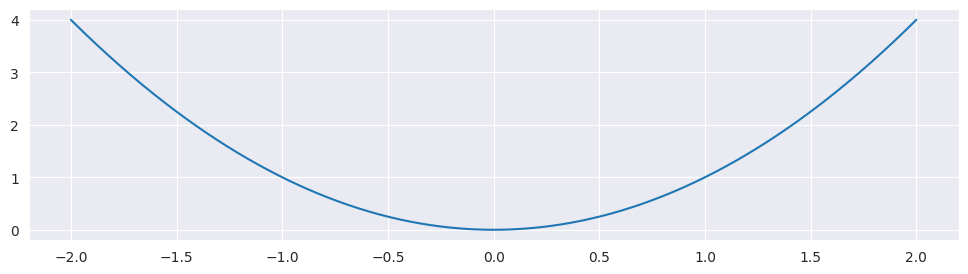

In [5]:
plt.figure(figsize=(12,3))
plt.plot(valid_x, potential(valid_x))

In [13]:
# Based on https://medium.com/@natsunoyuki/quantum-mechanics-with-python-de2a7f8edd1f
@tf.function
def generate_hamiltonian(omega: tf.float64) -> tf.Tensor:

    # Prepare indices
    r = tf.range(Settings.resolution)
    ii = tf.concat([r, r[1:], r[:-1]], axis=0)
    jj = tf.concat([r, r[:-1], r[1:]], axis=0)
    idx = tf.stack([ii, jj], axis=1)
    values = tf.concat([
        2 * tf.ones(Settings.resolution) / ( delta_x **2 ) + omega**2 * valid_x**2, # diagonal
        -1 * tf.ones(Settings.resolution - 1) / delta_x ** 2, # above diagonal
        -1 * tf.ones(Settings.resolution - 1) / delta_x ** 2# under diagonal
    ], axis=0)

    return tf.cast(
        tf.scatter_nd(idx, values, [Settings.resolution, Settings.resolution]),
        dtype=tf.complex64
    )

    # # P^2 term
    # temp_hamiltonian = 2 * tf.eye(Settings.resolution)
    # for i in range(Settings.resolution - 1):
    #     temp_hamiltonian[i, i + 1] = -1
    #     temp_hamiltonian[i + 1, i] = -1
    #
    # # # Turns the space cyclic. Useful for modelling ring interferometry
    # # inner_hamiltonian[0, resolution - 1] = -1
    # # inner_hamiltonian[resolution - 1, 0] = -1
    #
    # temp_hamiltonian = temp_hamiltonian / delta_x ** 2
    #
    # # V(X) term
    # for i in range(Settings.resolution):
    #     temp_hamiltonian[i, i] = temp_hamiltonian[i, i] + omega**2 * (valid_x[i] - center)**2
    #
    # return temp_hamiltonian.tocsc()

hamiltonian = generate_hamiltonian(omega=Settings.omega)

# Energy levels

I0000 00:00:1739168226.866429   46251 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x422b0be0


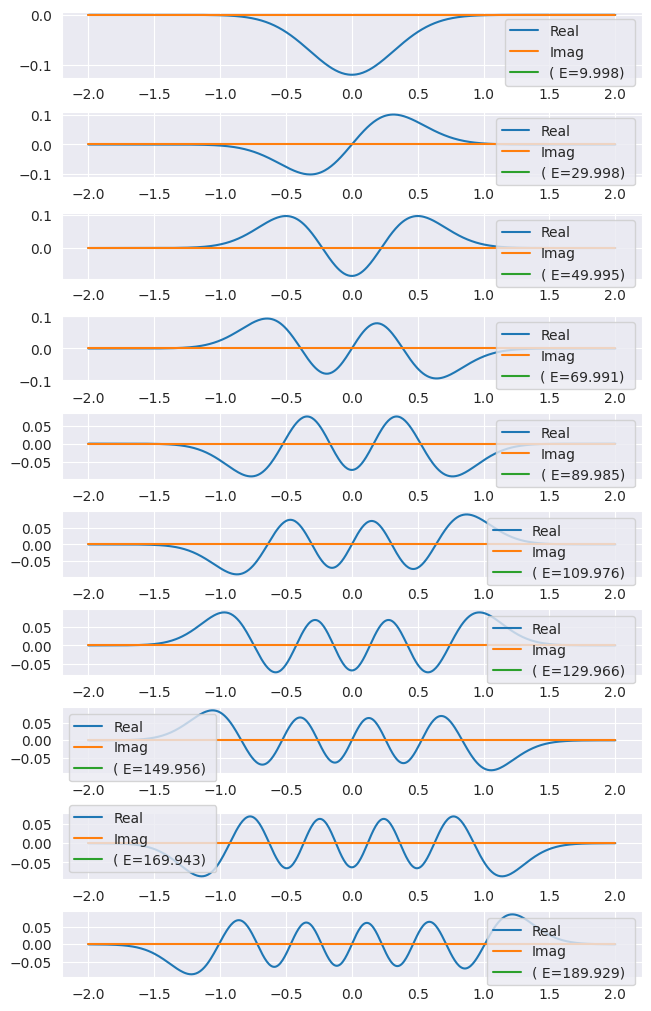

In [14]:
eigenvalues, eigenvectors = tf.linalg.eigh(tensor=hamiltonian)
eigenvalues = eigenvalues[:Settings.number_of_energy_levels]
eigenvectors = tf.transpose(eigenvectors)[:Settings.number_of_energy_levels]

fig, axes = plt.subplots(Settings.number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(Settings.number_of_energy_levels)
for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors)):
    axes[i].plot(valid_x.numpy(), np.real(vector.numpy()), label=f"Real")
    axes[i].plot(valid_x.numpy(), np.imag(vector.numpy()), label=f"Imag")
    axes[i].plot([],[], label=f"( E={np.real(val):.3f}) ")
    axes[i].legend(loc='best')

plt.show()

# Orthonormality check

<Axes: >

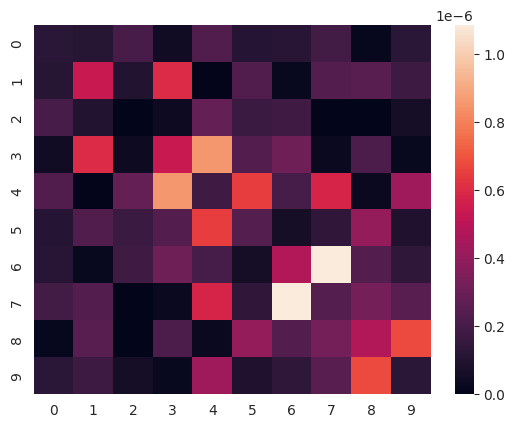

In [15]:
# Ideally this should all be zeroes
error_matrix = np.abs(eigenvectors @ tf.transpose(eigenvectors)) - tf.eye(Settings.number_of_energy_levels)
sns.heatmap(np.abs(error_matrix.numpy()))

# Origin state

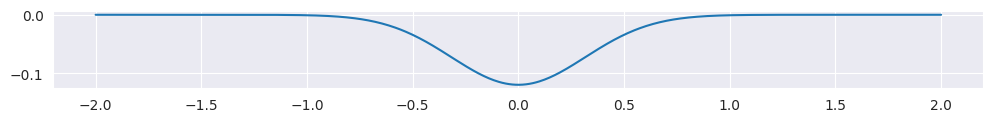

In [16]:
origin_state = eigenvectors[0, :]
plt.figure(figsize=(12,1))
plt.plot(valid_x, np.real(origin_state.numpy()))

# Target state

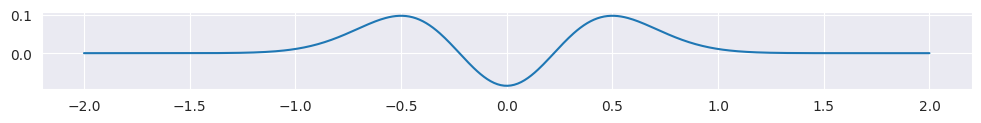

In [17]:
target_state = eigenvectors[Settings.target_energy_level, :]
plt.figure(figsize=(12,1))
plt.plot(valid_x, np.real(target_state.numpy()))

# Auxiliary functions

We will split the time evolution into time_intervals. We want to find a vector of time choices that maximizes the final fidelity between the target state, and the evolved state

## Fidelity
$\mathcal{F} \coloneqq |\braket{\rho_a | \rho_b} |^2$

In [38]:
@tf.function
def fidelity(state_a: tf.Variable, state_b: tf.Variable) -> tf.complex64:
    return tf.abs(tf.reduce_sum(tf.multiply(state_a, state_b))) ** 2

## State evolution
$\ket{\phi_{t+s}} = e^{isH_s} \ket{\phi_t}$

In [28]:
# I use model following tensorflow's nomenclature
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
# We have a parameterised model for time evolution, and we build our loss based on the model's "prediction"/evolved state
def model(omega_list: tf.Variable, time_list:tf.Variable) -> tf.Variable:
    assert tf.size(omega_list) == tf.size(time_list), f"The length of omega_list does not match the length of time_list: {tf.size(omega_list)}!={tf.size(time_list)}"

    internal_evolved_state = origin_state
    for temp_omega, temp_time in zip(omega_list, time_list):
        internal_evolved_state = tf.linalg.expm(tf.multiply(-1j * temp_time, generate_hamiltonian(omega=temp_omega))) @ internal_evolved_state
    return evolved_state

## Loss function

In [27]:
tf.math.reduce_min(tf.cast(target_state, tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.08453860133886337>

In [20]:
def loss(
        internal_evolved_state: tf.Variable,
        internal_omega_list: tf.Variable,
        internal_time_list: tf.Variable,
        target_state: tf.Variable
) -> tf.Variable:

    fidelity_loss = 10**3 * (1 - fidelity(internal_evolved_state, target_state))**2
    time_loss = 10**-4 * tf.math.divide(tf.math.reduce_sum(internal_time_list) - Settings.total_evolution_time, Settings.total_evolution_time)**2
    negative_time_loss = -1 * 10**3 * np.min([np.min(internal_time_list), 0])
    negative_omega_loss = -1 * 10**3 * np.min([np.min(internal_omega_list), 0])
    large_omega_loss = 10**-4 * np.max(internal_omega_list)**2
    non_normalized_final_state_loss = (np.linalg.norm(internal_evolved_state) - 1)**2

    return fidelity_loss + time_loss + negative_time_loss + negative_omega_loss + large_omega_loss + non_normalized_final_state_loss

    # # Useful for seeing progress during the optimization process
    # if .1 > np.random.uniform(): # Avoid over printing
    #     print(f' < {100*fidelity(internal_evolved_state, target_state):.1f}% | {loss_value:.1f} | {", ".join(["{:.1f}".format(x) for x in all_inputs])} > ')

## Plotting

In [39]:
def plot_waves(omega_list: tf.Variable, time_list: tf.Variable, show_fidelity:bool = True) -> None:

    # assert len(omega_list) == len(time_list), f"The length of omega_list does not match the length of time_list: {len(omega_list)}!={len(time_list)}"

    n_time_intervals = Settings.n_time_intervals
    evolved_state = deepcopy(origin_state)
    fig, axes = plt.subplots(n_time_intervals + 1, 1, layout='constrained')
    fig.set_figheight(n_time_intervals * 2)
    axes[0].plot(valid_x, np.real(evolved_state), label="Real")
    axes[0].plot(valid_x, np.imag(evolved_state), label="Imag")
    if show_fidelity:
        axes[0].plot([], [], label=f"$\\mathcal{{F}}={fidelity(evolved_state, target_state):.2f}$")
    axes[0].legend(loc="best")

    for i, (temp_omega, temp_time) in enumerate(zip(omega_list, time_list)):
        unitary = tf.linalg.expm(-1j * generate_hamiltonian(omega=temp_omega) * temp_time)
        evolved_state = unitary * evolved_state
        axes[i+1].plot(valid_x, np.real(evolved_state), label="Real")
        axes[i+1].plot(valid_x, np.imag(evolved_state), label="Imag")
        axes[i+1].plot(valid_x, np.real(target_state), label="target")
        if show_fidelity:
            axes[i+1].plot([], [], label=f"$\\mathcal{{F}}={100*fidelity(evolved_state, target_state):.2f}\\%$")
            axes[i+1].plot([] , [], label=f"$\\omega={temp_omega:.2f}$")
            axes[i+1].plot([] , [], label=f"$t={temp_time:.2f}$")
        axes[i+1].legend(loc="best")

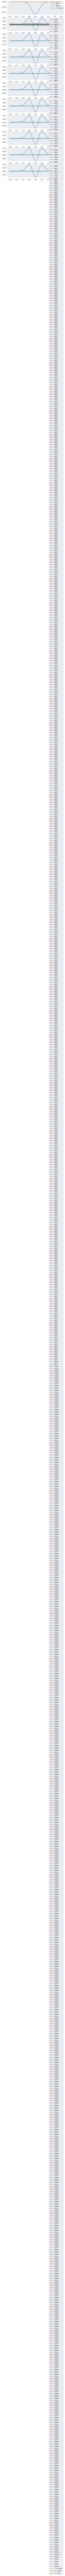

In [40]:
plot_waves(
    omega_list=range(Settings.n_time_intervals),
    time_list=np.ones(Settings.n_time_intervals)
)

# Optimization loop

In [ ]:
initial_guess = np.concatenate((
    np.random.uniform(
        low=0,
        high=1.5 * Settings.omega,
        size=Settings.n_time_intervals
    ), # Initial omega
    np.random.uniform(
        low=Settings.time_delta,
        high=2*Settings.time_delta,
        size=Settings.n_time_intervals
    ) # Initial time interval
))
initial_guess

In [ ]:
# TODO: GPU based solution
# https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/bfgs_minimize
results = minimize(
    loss,
    x0 = initial_guess,
    method="BFGS",
    # method="Nelder-Mead",
    # method="Powell",
)
results

# Plots

In [ ]:
final_omega_list, final_time_list = np.resize(results.x, (2,int(len(results.x)/2)))

In [ ]:
plt.figure(figsize=(12,1))
plt.step(x=[0] + np.cumsum(final_time_list), y=final_omega_list + [final_omega_list[-1]])

In [ ]:
plot_waves(final_omega_list, final_time_list)

In [ ]:
plt.figure(figsize=(8,1))
plt.plot(valid_x, np.real(target_state), label="Real")
plt.plot(valid_x, np.imag(target_state), label="Imag")
plt.legend(loc="best")

In [ ]:
evolved_state = model(final_omega_list, final_time_list)
plt.figure(figsize=(8,1))
plt.plot(valid_x, np.real(evolved_state), label="Real")
plt.plot(valid_x, np.imag(evolved_state), label="Imag")
plt.legend(loc="best")